In [1277]:
import pandas as pd
import math

"""
Data acquisition of data for sonification, plus some preprocessing
"""
# Read the data in
df = pd.read_csv('backward_all.csv')

In [1278]:
# Convert to negative weeks to death, so numbers are in chronological order
df = df.sort_values(by='weeks_to_death', ascending=False)

In [1279]:
#df.head()

In [1280]:
# Select var average for FEMALES in FMC_EUROPE
# Get subset of the dataframe to sonify - already sorted by weeks_to_death desc
test_var = df.loc[(df['database'] == 'FMC_EUROPE') & (df['MALE'] == 0), 'pre_sbp_avg']
#test_var = df.loc[(df['database'] == 'FMC_EUROPE') & (df['MALE'] == 0), 'albumin_avg']

#take 5 week rolling average, then normalize the values
test_var = test_var.rolling(5).mean()[5:]
test_var = (test_var - test_var.min())/(test_var.max() - test_var.min())

In [1281]:
"""
Global Variables
"""
# Music Config
BPM = 120 # Beats per minute, e.g. 60, 75, 100, 120, 150
DIVISIONS_PER_BEAT = 4 # e.g. 4 = quarter notes, 8 = eighth notes
VARIANCE_MS = 20 # +/- milliseconds an instrument note should be off by to give it a little more "natural" feel
VARIANCE_RATE = 0 # for adding variance to the playback rate
BEAT_MS = round(60.0 / BPM * 1000) # ms in a beat - 500
# File config
INSTRUMENTS_INPUT_FILE = 'son_instruments.csv'
INSTRUMENTS_OUTPUT_FILE = 'data/chk_instruments.csv'
SEQUENCE_OUTPUT_FILE = 'data/chk_sequence.csv'
INSTRUMENTS_DIR = 'instruments/'

In [1282]:
"""
Helper functions
"""
# For getting pseudo-random numbers
def halton(index, base):
    result = 0.0
    f = 1.0 / base
    i = 1.0 * index
    while(i > 0):
        result += f * (i % base)  
        i = math.floor(i / base)
        f = f / base
    return result

In [1283]:
"""
Data acquisition of instruments
"""
# Read in instruments data, do some preprocessing
instruments = pd.read_table(INSTRUMENTS_INPUT_FILE)
instruments['Type'] = instruments['Type'].str.lower().str.replace(' ','_')
instruments['File'] = INSTRUMENTS_DIR + instruments['File']

In [1284]:
"""
Writing to the sequence file that will create the musical sequence (the song)
@param  gain        The gain (volume) of the instrument - this will be equivilent to the value of the variable that week
@param  instrument  The current instrument being added
@param  ms          The current location in the sequence (song)
@param  duration    The number of ms that makes up a data point (week) in the sequence (song)
"""
"""
Explanation of Tempo Offset
    Tempo Offset of 0 will play the instrument on the fitst beat
    Tempo Offset of 0.5 will play the instrument on the offbeat
    Tempo Offset of 1 will play the instrument on the second beat
"""
def addBeatsToSequence(gain, instrument, ms, duration):
    global sequence
    global hindex
    # Will this instrument be offset? Get the amount of ms the instrument will be offset
    offset_ms = int(instrument['Tempo Offset'] * BEAT_MS)
    # Add the offset to the place in the sequence (song)
    ms += offset_ms
    # Generate a pseudo-random number to create a pseudo-random variance
    h = halton(hindex, 3)
    variance = int(h * VARIANCE_MS * 2 - VARIANCE_MS)
    rate_variance = float(h * VARIANCE_RATE * 2 - VARIANCE_RATE) # This is currently always 0
    sequence.append({
        'instrument_index': instrument['index'],
        'instrument': instrument,
        'position': 0,
        'gain': round(gain, 2),
        'rate': 0.5 + rate_variance, # CRK try as 1.0 as well; do we need variance_rate
        'elapsed_ms': max([ms + variance, 0])
    })
    hindex += 1
    # increment where we are in the song
    ms += duration

In [1285]:
"""
This is where the sequence is built
    Make a set duration for how long we will spend on each data point (in this case, each data point represents a week)
    Loop through each instrument in the given instrument csv
    For each instrument, loop through the variable values
        An instrument is played for the variable if the value of the variable is greater than the allowed variable for the instrument
            If an instrument is played, add that beat to the sequence file
        Incrument where we are in the song (ms defines where we are in the song)
"""
# Amount of time, in MS, to spend on each data point
week_duration = 500
sequence = []
hindex = 0

# Loop through each instrument
for index, instrument in enumerate(instruments.iterrows()):
    # ms represents the current place in the sequence (song)
    ms = 0
    # Skip the first line of the instrument file (headers)
    instrument = instrument[1]
    instrument['index'] = index
    min_var = instrument['Min Var']
    #Loop through each week's value
    for week_val in test_var:
        play_instrument = (week_val*100) > min_var
        if play_instrument:
            addBeatsToSequence(week_val, instrument, ms, week_duration)
        ms += week_duration

In [1286]:
# Sort sequence so beats happen in chronological order
sequence = sorted(sequence, key=lambda k: k['elapsed_ms'])

# Add milliseconds to sequence
elapsed = 0
for index, step in enumerate(sequence):
    sequence[index]['milliseconds'] = step['elapsed_ms'] - elapsed
    elapsed = step['elapsed_ms']


In [1287]:
"""
Write to the files that will be used by ChucK
"""
import csv
import os 

# Write instruments to file
with open(INSTRUMENTS_OUTPUT_FILE, 'w') as f:
    w = csv.writer(f)
    for index, instrument in enumerate(instruments.iterrows()):
        w.writerow([index])
        w.writerow([instrument[1]['File']])
    f.seek(0, os.SEEK_END) # remove newline
    f.truncate()
    print('Successfully wrote instruments to file: '+ INSTRUMENTS_OUTPUT_FILE)

# Write sequence to file
with open(SEQUENCE_OUTPUT_FILE, 'w') as f:
    w = csv.writer(f)
    for step in sequence:
        w.writerow([step['instrument_index']])
        w.writerow([step['position']])
        w.writerow([step['gain']])
        w.writerow([step['rate']])
        w.writerow([step['milliseconds']])
    f.seek(0, os.SEEK_END) # remove newline
    f.truncate()
    print('Successfully wrote sequence to file: '+ SEQUENCE_OUTPUT_FILE)


Successfully wrote instruments to file: data/chk_instruments.csv
Successfully wrote sequence to file: data/chk_sequence.csv


In [1288]:
#instrument

In [1289]:
#test_var

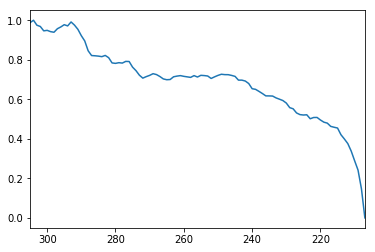

In [1290]:
import matplotlib.pyplot as plt

test_var.plot()
plt.show()

In [1291]:
#df.head()

In [1292]:
#instruments